#Heart Disease Prediction (Classification)

Building a machine learning model that can accurately predict whether a patient has heart disease based on a set of medical attributes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

Creating df

In [2]:
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

100%|██████████| 12.4k/12.4k [00:00<00:00, 6.30MB/s]

Extracting files...
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


##Exploratory Data Analysis

In [3]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

## Analyzing the Target Variable

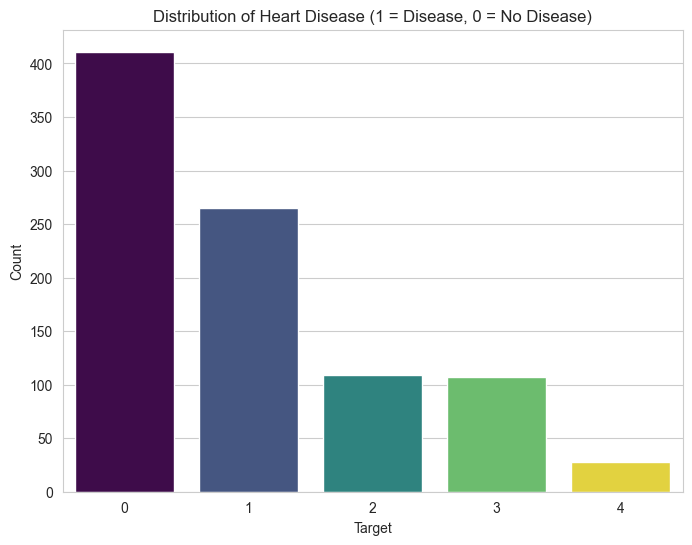

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

**Observation:** The dataset is fairly balanced, with a slightly higher number of patients having heart disease.

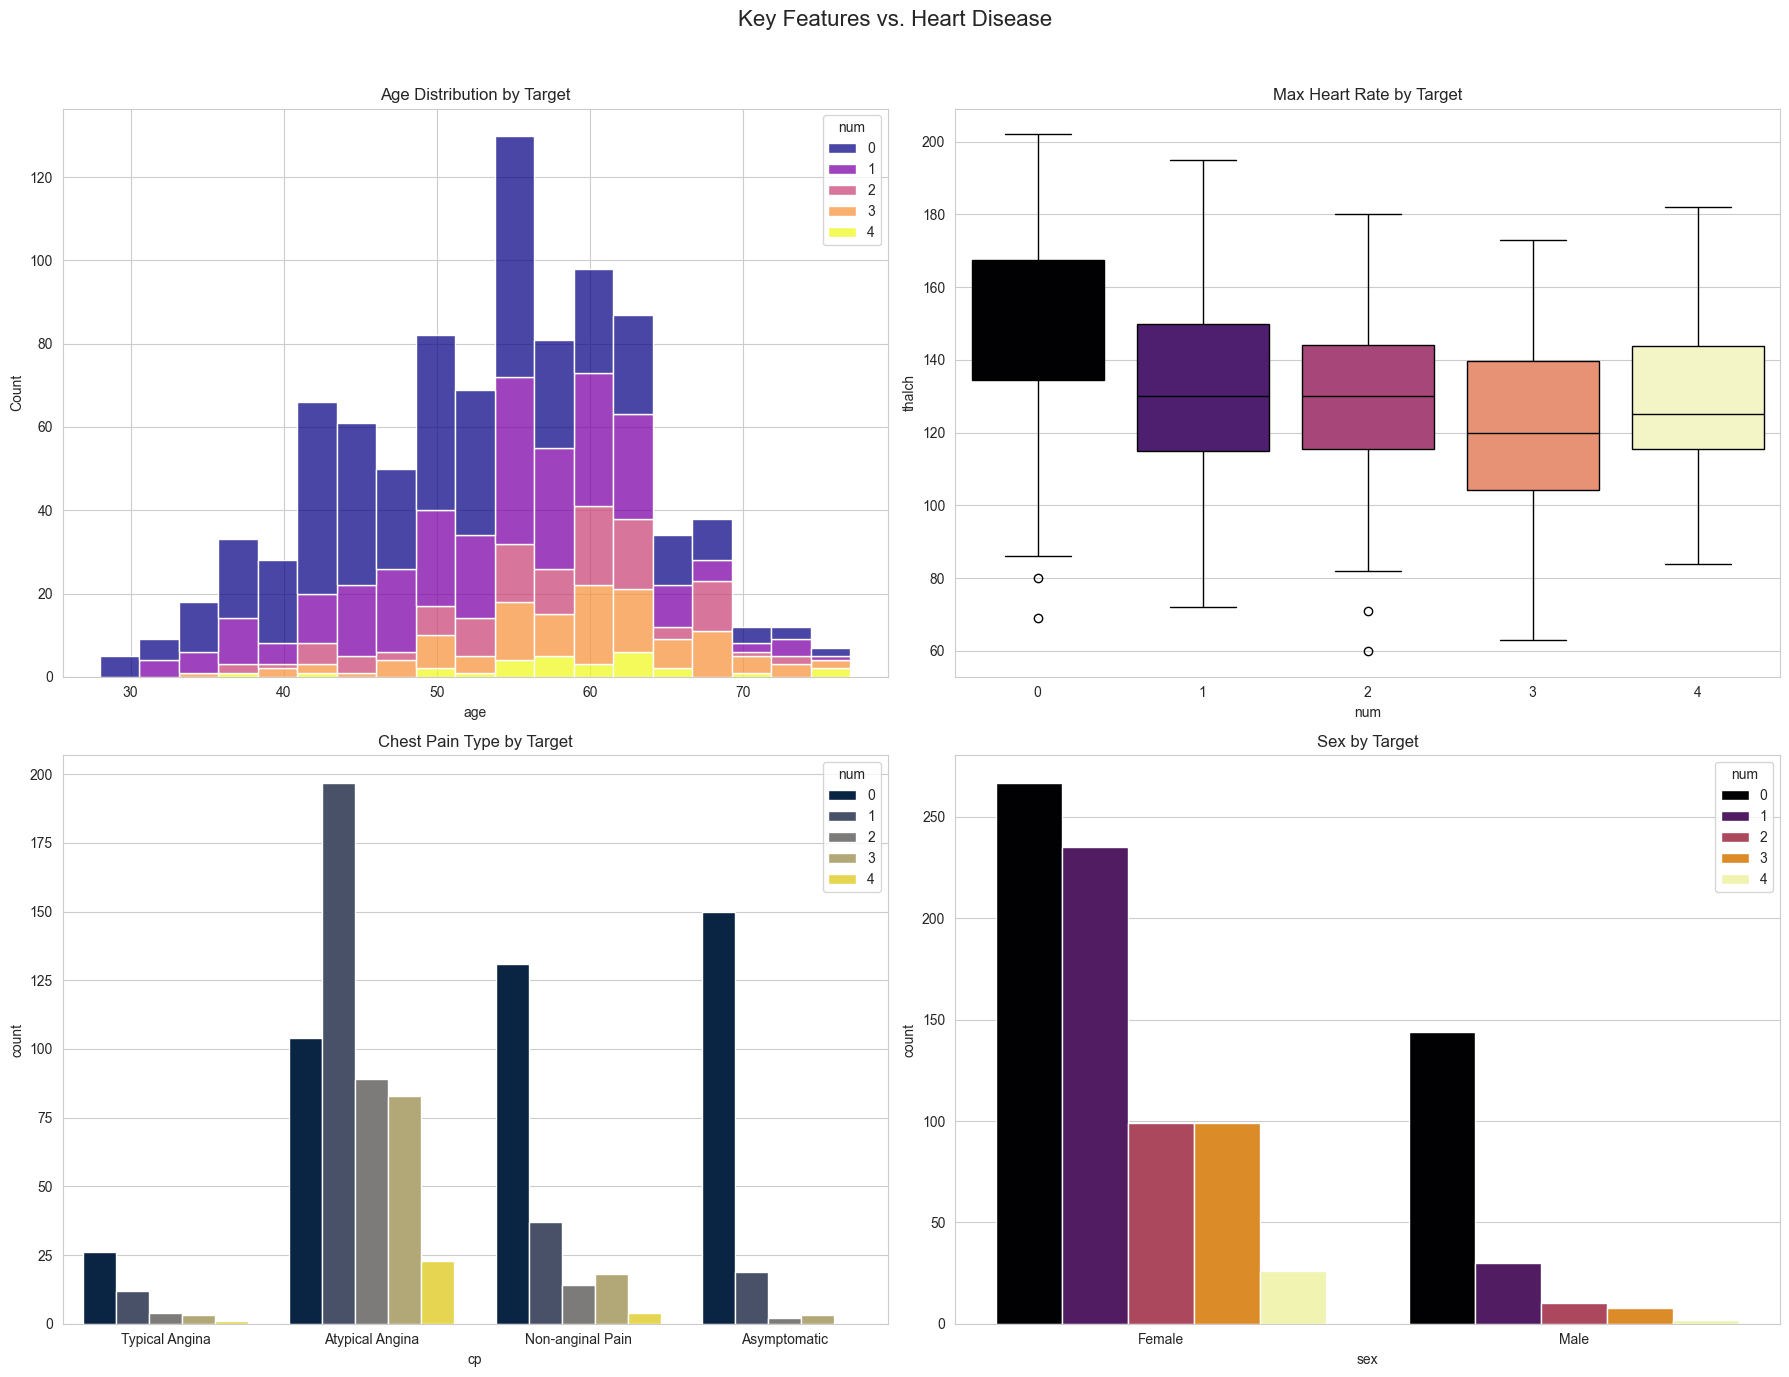

In [5]:
# Key features vs target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Observation:**
- `thalach`: Patients with heart disease tend to have a lower maximum heart rate.
- `cp`: Patients with chest pain types 1 and 2 are more likely to have heart disease.
- `Sex`: A higher proportion of females in this dataset have heart disease compared to males.

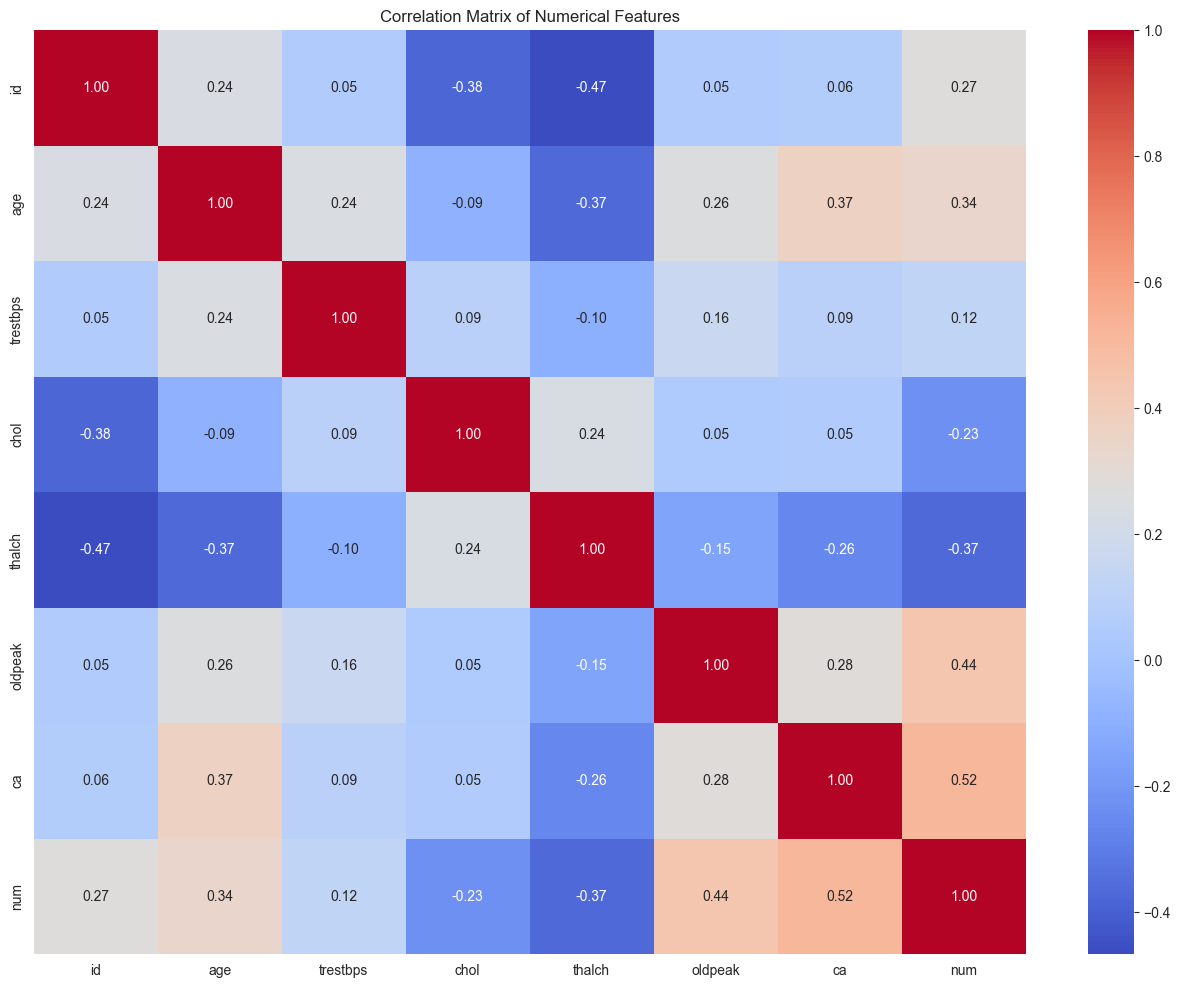

In [6]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

##Data Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [8]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Remove the target var, id and dataset cols

In [9]:
X = df.drop('num', axis=1)
X = X.drop(['id', 'dataset'], axis=1)
y = df['num']

In [10]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

In [11]:
# imputing with mean value
for col in numerical_features:
    mean_val = X[col].mean()
    X[col].fillna(mean_val, inplace=True)

print("Missing values after imputation:")
print(X[numerical_features].isnull().sum())

Missing values after imputation:
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
ca          0
dtype: int64


C:\Users\Param\AppData\Local\Temp\ipykernel_6908\2187063353.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_val, inplace=True)


In [12]:
# Manually impute missing categorical values with the mode
for col in categorical_features:
    mode_val = X[col].mode()[0]
    X[col].fillna(mode_val, inplace=True)

# Verify that there are no missing values in categorical features
print("Missing values after imputation:")
print(X[categorical_features].isnull().sum())

Missing values after imputation:
sex        0
cp         0
fbs        0
restecg    0
exang      0
slope      0
thal       0
dtype: int64


C:\Users\Param\AppData\Local\Temp\ipykernel_6908\2503727026.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mode_val, inplace=True)
C:\Users\Param\AppData\Local\Temp\ipykernel_6908\2503727026.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col].fillna(mode_val, inplace=True)


In [13]:
# Scaling numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# One-Hot Encoding categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Display the processed data
print("Processed data shape:", X.shape)
display(X.head())

Processed data shape: (920, 18)


,age,trestbps,chol,thalch,oldpeak,ca,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1.007386,0.698041,0.311021,0.495698,1.349421,-1.249371,True,False,False,True,True,False,False,False,False,False,False,False
1,1.432034,1.511761,0.797713,-1.175955,0.589832,4.292099,True,False,False,False,False,False,False,True,True,False,True,False
2,1.432034,-0.658158,0.274289,-0.340128,1.634267,2.444942,True,False,False,False,False,False,False,True,True,False,False,True
3,-1.752828,-0.115679,0.467130,1.968345,2.488805,-1.249371,True,False,True,False,False,True,False,False,False,False,True,False
4,-1.328180,-0.115679,0.044717,1.371326,0.494884,-1.249371,False,True,False,False,False,False,False,False,False,True,True,False


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
X_train

,age,trestbps,chol,thalch,oldpeak,ca,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
637,-0.054235,-0.658158,-1.828588,-1.693371,-0.834397,-2.050756e-16,True,True,False,False,False,True,False,False,True,False,True,False
743,2.175168,0.000000,-1.828588,0.000000,0.000000,-2.050756e-16,True,False,True,False,False,True,False,False,True,False,True,False
643,-0.054235,-0.115679,-1.828588,-0.101321,0.115089,-2.050756e-16,True,False,False,False,False,False,False,True,True,False,False,True
694,0.901224,-0.929398,-1.828588,-2.608800,-1.309140,-2.050756e-16,True,False,False,False,False,True,False,True,True,False,True,False
913,0.901224,1.403265,-0.267500,0.018083,-0.834397,-2.050756e-16,True,False,False,False,False,False,True,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.903531,-1.200638,0.595690,-0.220724,0.304987,-1.249371e+00,True,False,False,True,False,True,False,False,True,False,False,True
242,-0.478883,-0.115679,0.641604,1.013115,-0.834397,-1.249371e+00,False,False,False,False,False,True,False,False,False,True,True,False
55,0.051927,-0.441166,0.614056,-1.136154,1.254473,5.977853e-01,True,False,False,False,False,False,False,True,True,False,False,True
21,0.476575,0.969281,0.770164,0.973314,0.115089,-1.249371e+00,False,False,False,True,True,False,False,False,False,True,True,False


##Model building and training

Logistic regression

In [16]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred_lr = logreg_model.predict(X_test)

In [17]:
y_pred_lr

array([1, 1, 0, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1, 2, 1,
       0, 0, 3, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 3, 1, 2, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 3, 0, 2, 0, 1, 1,
       0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 3, 3, 0, 2, 0, 3,
       1, 0, 0, 3, 1, 2, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 3, 2, 0, 0, 4, 0, 1, 0, 3, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 3, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 3,
       0, 0, 0, 1, 0, 3, 2, 1], dtype=int64)

##Random Forest Classifier

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

##Support Vector Machine (SVM)

In [19]:
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

## K Nearest Neighbours (KNN)

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

##Model Evaluation

In [21]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.46      0.57      0.51        53
           2       0.33      0.14      0.19        22
           3       0.23      0.24      0.23        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.37      0.36      0.35       184
weighted avg       0.56      0.59      0.57       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.56      0.57      0.56        53
           2       0.12      0.09      0.10        22
           3       0.16      0.14      0.15        21
           4       1.00      0.17      0.29         6

    accuracy                           0.57       184
   macro avg       0.51      0.36      0.38       184
we

**Observations:** Support Vector Machine (SVM) Classifier performs slightly better than the other models

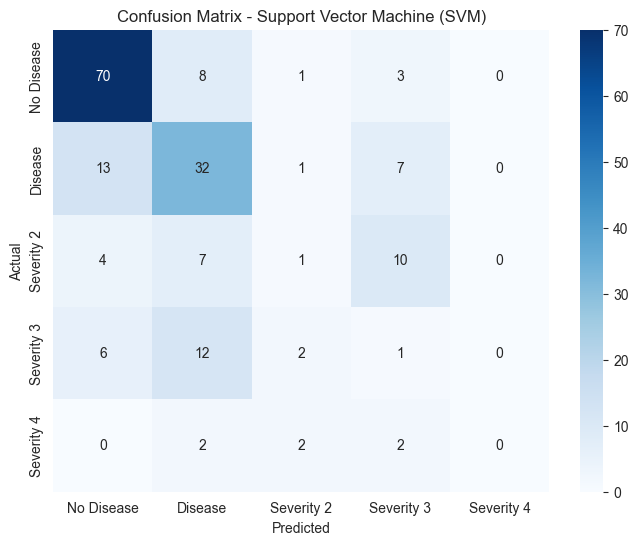

In [22]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

## Feature importance

Random forest allows us to see which features were most influential in making predictions

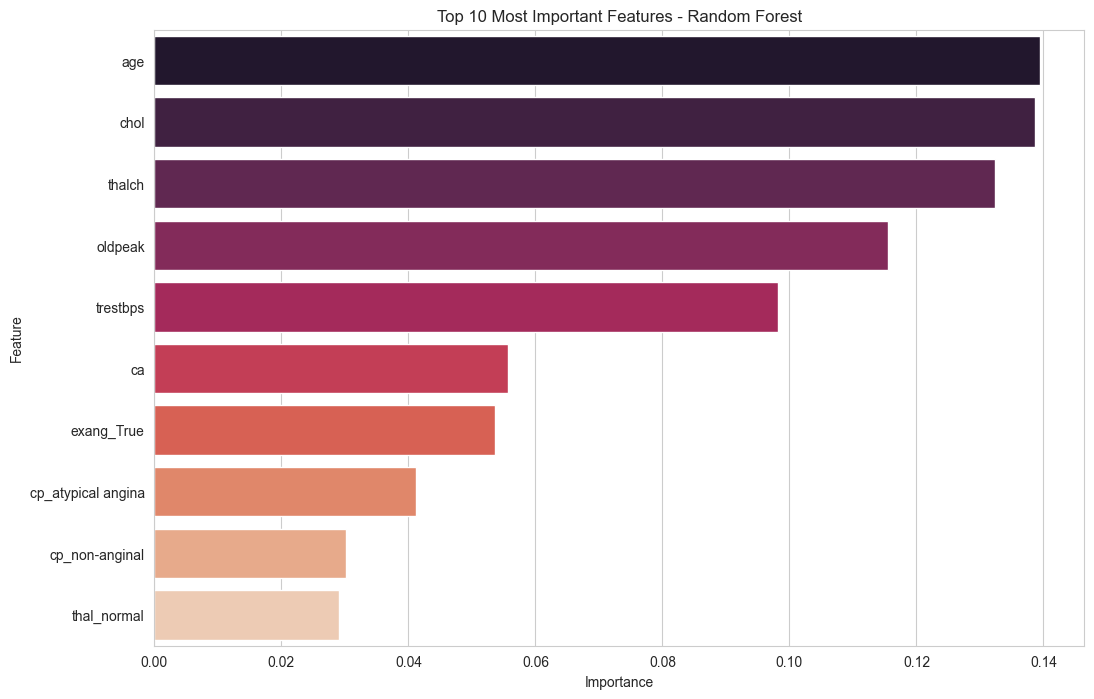

In [23]:
# Get feature names from the training data after preprocessing
feature_names = X_train.columns

# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

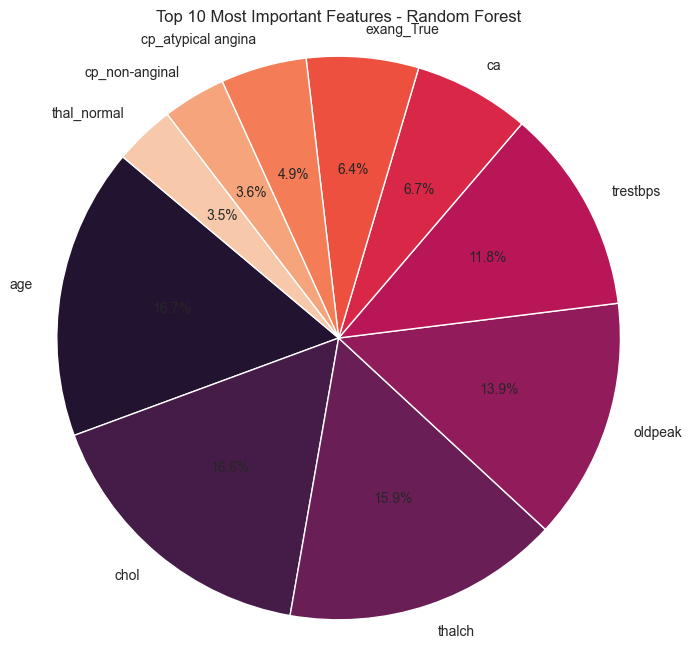

In [26]:
# Extract top 10 features and their importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
labels = top_features['Feature']
sizes = top_features['Importance']
colors = sns.color_palette('rocket', len(labels))

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Most Important Features - Random Forest')
plt.axis('equal')  # Ensures pie is drawn as a circle
plt.show()